TO DO:

1- DATA AUGMENTATION

2- BETTER MODEL / PROBABLY USE PRETRAINED

3- AVOID OVERFITTING

4- CHECK WHY THE ML MODELS ARE GETTING 100% ACC (LEAKAGE COMES FROM METADATA 
FEATURES BUT CAN'T FIND THE REASON)

5- CAREFUL, WE SHOULD CONSIDER HOW WE WANT TO SPLIT THE DATA, SHOULD WE KEEP ALL DAYS IN THE SAME SET(TRAIN/TEST) WOULD IT BE LEAKAGE IF WE HAVE A LOCATION BOTH IN TEST AND TRAIN CONSIDERING I don't think the methane will change much

6- Add AUC TO THE MODEL CONSIDERING THIS IS WHAT WE ARE EVALUATED ON.

# Methane detection hackathon

### Goal : detect methane leaks in the atmosphere based on satelite images

It's a binary classification problem : does the image contain a plume of methane or not ?

In order to do that, a dataset containing images in `tif` format is provided along with metadata including :
* path
* date the satelite image was taken
* class (`plume` or `no_plume`)
* an ID identifying the location
* latitude and longitude coordinates locating the center of the plume (`lat`,`lon`)
* pixel coordinates locating the center of the plume in the image (`coord_x`,`coord_y`). Please be midnful that the axis origin (0,0) is at the top left corner of the image

The dataset contains two folders:
- `plume` : contains all images with plumes of methane.
- `no_plume` : contains all images with no plume of methane.


**All images have a resolution of 64x64 and they are in gray scale (2D-arrays).**

Images names are written in the following format `{date}_methane_mixing_ratio_id_{location id}.tif`

# Necessary imports

### 1. Install requirements

In [1]:
!pip install rasterio
!pip install tifffile

     ---------------------------------------- 0.0/22.3 MB ? eta -:--:--
     --------------------------------------- 0.0/22.3 MB 660.6 kB/s eta 0:00:34
     --------------------------------------- 0.0/22.3 MB 660.6 kB/s eta 0:00:34
     --------------------------------------- 0.0/22.3 MB 245.8 kB/s eta 0:01:31
     --------------------------------------- 0.1/22.3 MB 359.3 kB/s eta 0:01:02
     --------------------------------------- 0.1/22.3 MB 438.1 kB/s eta 0:00:51
     --------------------------------------- 0.1/22.3 MB 386.4 kB/s eta 0:00:58
     --------------------------------------- 0.2/22.3 MB 525.1 kB/s eta 0:00:43
     --------------------------------------- 0.2/22.3 MB 626.9 kB/s eta 0:00:36
     --------------------------------------- 0.2/22.3 MB 554.9 kB/s eta 0:00:40
      -------------------------------------- 0.3/22.3 MB 610.3 kB/s eta 0:00:37
      -------------------------------------- 0.3/22.3 MB 677.0 kB/s eta 0:00:33
      -------------------------------------- 0.3


[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: C:\Users\felip\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


### 2. Import statements

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import os
import tifffile
import rasterio
from rasterio.plot import show, show_hist
import warnings
warnings.filterwarnings("ignore", category=rasterio.errors.NotGeoreferencedWarning)

# Loading the data

In [55]:
# Mount the drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### 3. Read an image

In [2]:
# Load the images

# FIRST THE NO PLUME

# Define the path to the directory containing the .tif images
#dir_path = '/content/drive/MyDrive/QB/data/images/no_plume'
dir_path='C:/Users/felip/Documents/GitHub/QB_methane_classification/data/data/images/no_plume'

# Create an empty list to store the loaded images
images = []

# Loop through all the .tif files in the directory
for file in os.listdir(dir_path):
    if file.endswith('.tif'):
        # Open the .tif file using rasterio
        with rasterio.open(os.path.join(dir_path, file)) as src:
            # Read the raster data as a NumPy array
            image = src.read()
            # Reverse the scale of the image
            #max_val = np.iinfo(image.dtype).max
            #image = max_val - image
            # Append the image to the list of loaded images
            images.append(image)

# Convert the list of loaded images to a numpy array
img_no_plume = np.array(images)
img_no_plume = img_no_plume.reshape(214, 64, 64, 1)

# THEN THE PLUME
# Define the path to the directory containing the .tif images
#dir_path = '/content/drive/MyDrive/QB/data/images/plume'
dir_path='C:/Users/felip/Documents/GitHub/QB_methane_classification/data/data/images/plume'
# Create an empty list to store the loaded images
images = []

# Loop through all the .tif files in the directory
for file in os.listdir(dir_path):
    if file.endswith('.tif'):
        # Open the .tif file using rasterio
        with rasterio.open(os.path.join(dir_path, file)) as src:
            # Read the raster data as a NumPy array
            image = src.read()
            # Reverse the scale of the image
            #max_val = np.iinfo(image.dtype).max
            #image = max_val - image
            # Append the image to the list of loaded images
            images.append(image)

# Convert the list of loaded images to a numpy array
img_plume = np.array(images)
img_plume = img_plume.reshape(214, 64, 64, 1)

In [3]:
print('We have', len(img_plume),'images with plume and', len(img_no_plume),'images with no plume')

We have 214 images with plume and 214 images with no plume


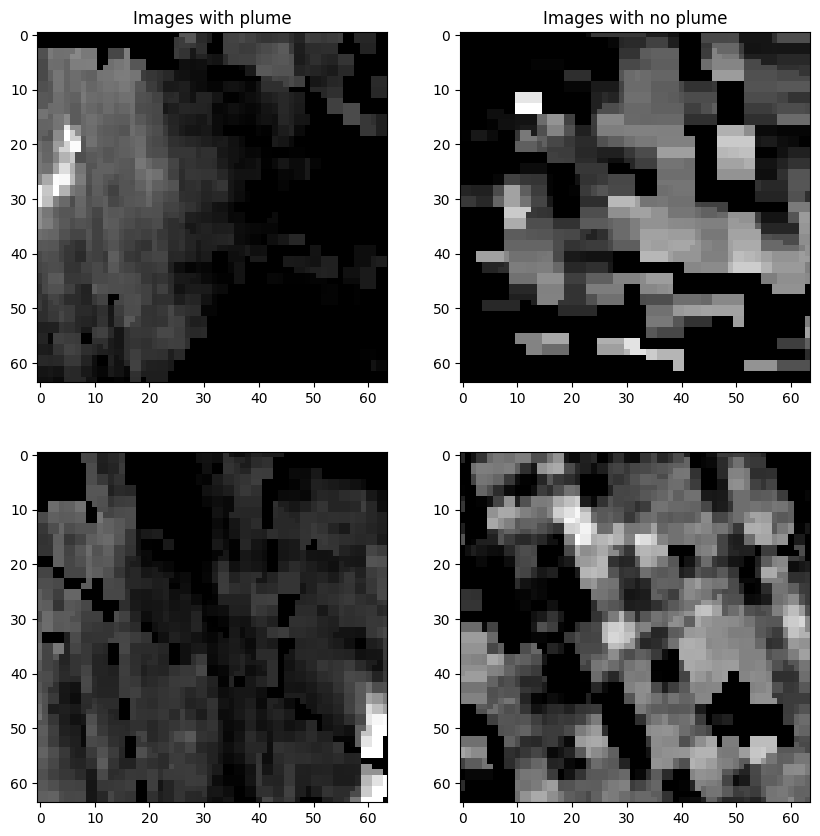

In [4]:
# Plotting a plume and a no plume image
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))

axs[0,0].imshow(img_plume[0], cmap='gray')
axs[1,0].imshow(img_plume[1], cmap='gray')
axs[0,0].set_title('Images with plume')

axs[0,1].imshow(img_no_plume[0], cmap='gray')
axs[1,1].imshow(img_no_plume[1], cmap='gray')
axs[0,1].set_title('Images with no plume')

plt.show()

Remark: I don't see any visible differentiation

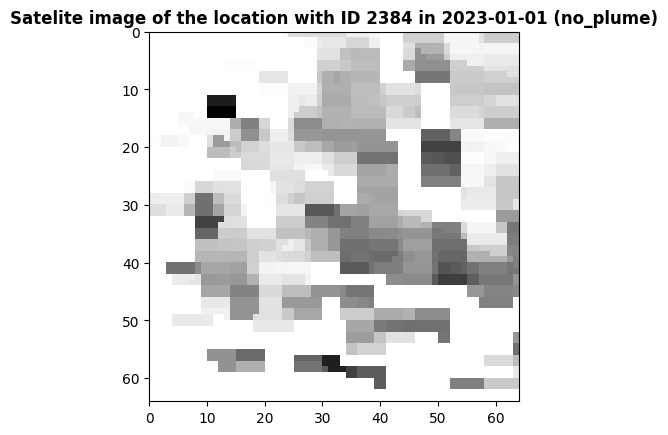

<Axes: title={'center': 'Satelite image of the location with ID 2384 in 2023-01-01 (no_plume)'}>

In [59]:
# This can also be used to plot
path = "/content/drive/MyDrive/QB/data/images/no_plume/20230101_methane_mixing_ratio_id_2384.tif"
example_image_no_plume = rasterio.open(path)
show(example_image_no_plume, cmap="Greys", title="Satelite image of the location with ID 2384 in 2023-01-01 (no_plume)")

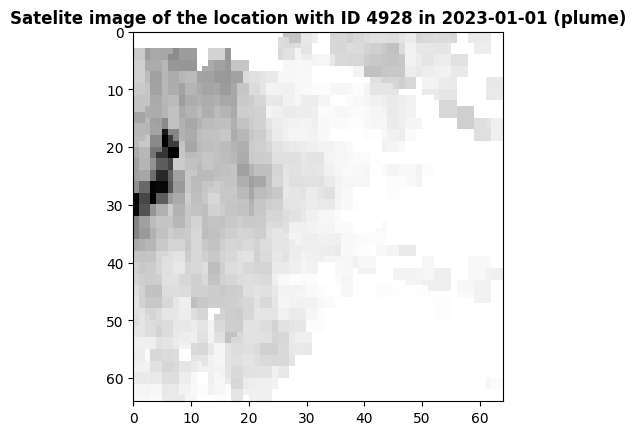

<Axes: title={'center': 'Satelite image of the location with ID 4928 in 2023-01-01 (plume)'}>

In [23]:
# This can also be used to plot
#path = "/content/drive/MyDrive/QB/data/images/plume/20230101_methane_mixing_ratio_id_4928.tif"
path='data/data/images/plume/20230101_methane_mixing_ratio_id_4928.tif'
example_image_plume = rasterio.open(path)
show(example_image_plume, cmap="Greys", title="Satelite image of the location with ID 4928 in 2023-01-01 (plume)")

### 4. Distribution of pixel intensity in greyscale

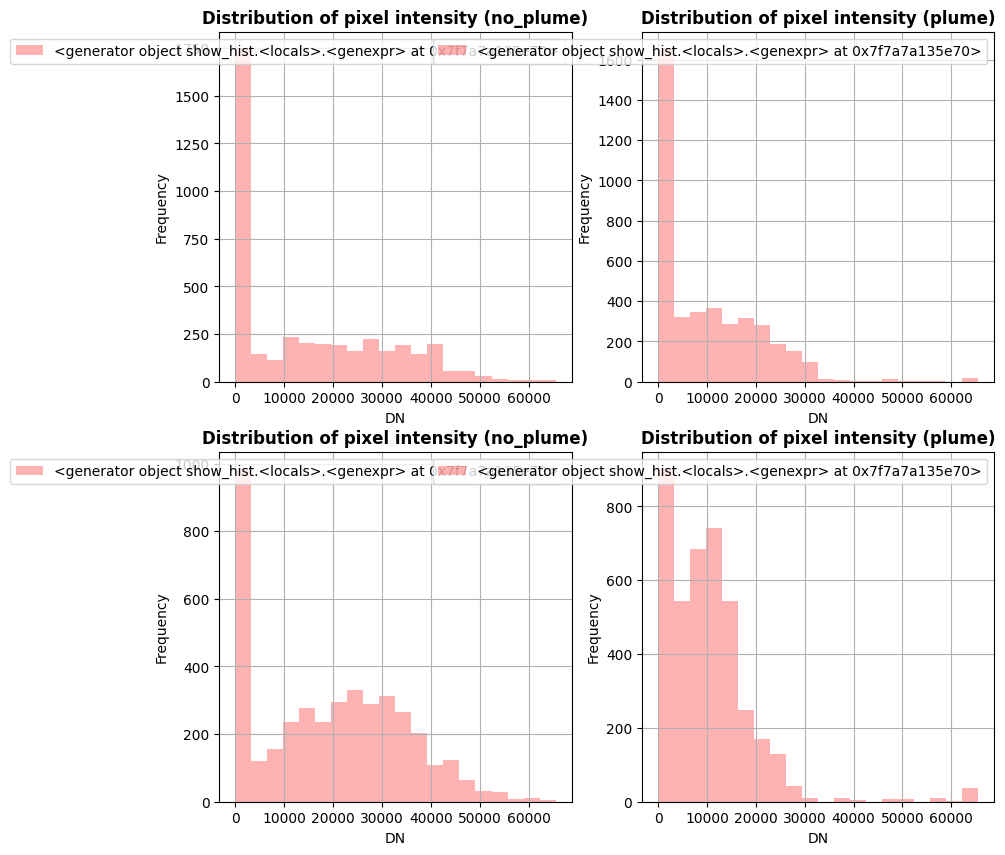

In [73]:
example_image_no_plume2 = rasterio.open('/content/drive/MyDrive/QB/data/images/no_plume/20230101_methane_mixing_ratio_id_4690.tif')
example_image_plume2 = rasterio.open('/content/drive/MyDrive/QB/data/images/plume/20230102_methane_mixing_ratio_id_1465.tif')


fig, ax = plt.subplots(nrows=2,ncols=2,figsize=(10,10))
show_hist(example_image_no_plume, bins=20, alpha=0.3, title="Distribution of pixel intensity (no_plume)", ax=ax[0,0])
show_hist(example_image_no_plume2, bins=20, alpha=0.3, title="Distribution of pixel intensity (no_plume)", ax=ax[1,0])

show_hist(example_image_plume, bins=20, alpha=0.3, title="Distribution of pixel intensity (plume)", ax=ax[0,1])
show_hist(example_image_plume2, bins=20, alpha=0.3, title="Distribution of pixel intensity (plume)", ax=ax[1,1])


### 5. Metadata

In [5]:
#metadata = pd.read_csv('/content/drive/MyDrive/QB/data/metadata.csv')
metadata = pd.read_csv('data\data\metadata.csv')

In [11]:
metadata.head(5)

,date,id_coord,plume,set,lat,lon,coord_x,coord_y,path
0,20230223,id_6675,yes,train,31.528750,74.330625,24,47,images/plume/20230223_methane_mixing_ratio_id_...
1,20230103,id_2542,yes,train,35.538000,112.524000,42,37,images/plume/20230103_methane_mixing_ratio_id_...
2,20230301,id_6546,yes,train,21.060000,84.936667,58,15,images/plume/20230301_methane_mixing_ratio_id_...
3,20230225,id_6084,yes,train,26.756667,80.973333,28,62,images/plume/20230225_methane_mixing_ratio_id_...
4,20230105,id_2012,yes,train,34.800000,40.770000,59,44,images/plume/20230105_methane_mixing_ratio_id_...


In [12]:
metadata.shape

(430, 9)

In [13]:
# Checking that the data is clean
metadata.describe()

,date,lat,lon,coord_x,coord_y
count,4.300000e+02,430.000000,430.000000,430.000000,430.000000
mean,2.023021e+07,29.219819,53.829356,31.448837,33.002326
std,9.208158e+01,15.522465,48.342344,16.800931,21.022410
min,2.023010e+07,-47.482444,-114.883661,0.000000,-9.000000
25%,2.023012e+07,23.603333,37.203908,18.000000,14.000000
50%,2.023021e+07,31.528750,61.693333,30.500000,34.500000
75%,2.023030e+07,36.136960,81.723449,44.000000,51.000000
max,2.023041e+07,68.570113,128.748371,64.000000,77.000000


In [14]:
len(metadata[metadata.coord_y<0])

11

Is it possible to have negative coordinates?

In [15]:
metadata['plume'].value_counts()

yes    216
no     214
Name: plume, dtype: int64

!!!!!Looks like I have 2 les plume than I should, why?

Idea: if the coordinates of no plume are arbitrary the we can set them to a specific value
Note that for plume there are negative values in the y coord!! (not for x though nor no plume)

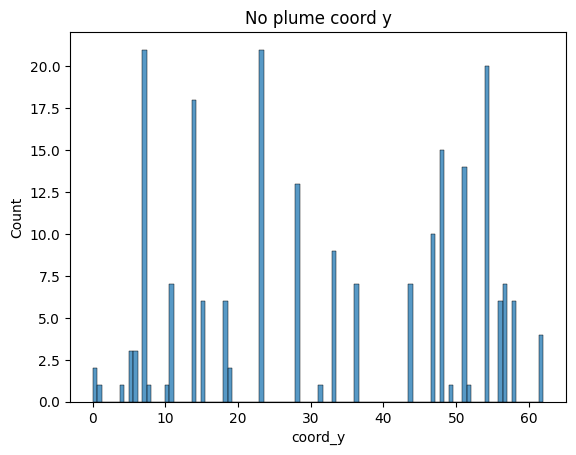

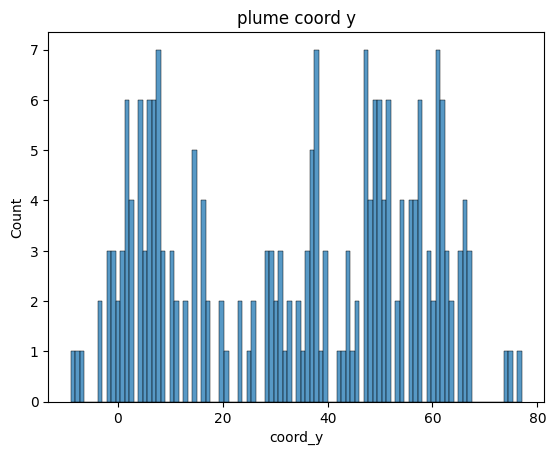

In [21]:

no_plume = metadata[metadata.plume=='no']
plume = metadata[metadata.plume=='yes']

sns.histplot(data=no_plume, x='coord_y',bins=100)
plt.title('No plume coord y')
plt.show()

sns.histplot(data=plume, x='coord_y',bins=100)
plt.title('plume coord y')
plt.show()

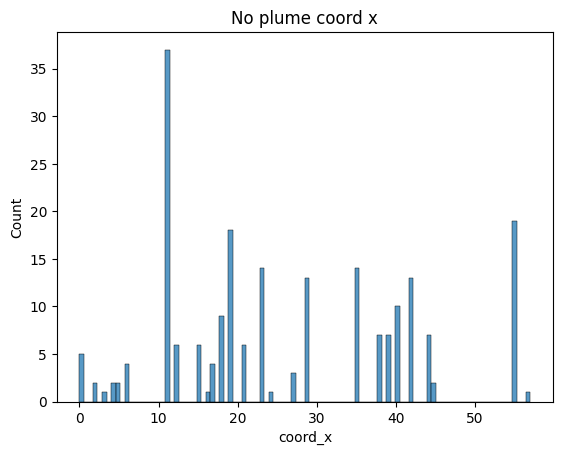

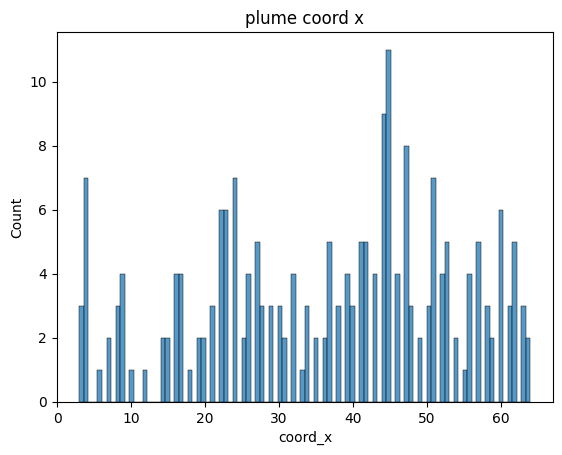

In [20]:
no_plume = metadata[metadata.plume=='no']
plume = metadata[metadata.plume=='yes']

sns.histplot(data=no_plume, x='coord_x',bins=100)
plt.title('No plume coord x')
plt.show()

sns.histplot(data=plume, x='coord_x',bins=100)
plt.title('plume coord x')
plt.show()

Looks like they make no sense

In [80]:
# Checking the ones I printed above (with the second method)
metadata[(metadata.id_coord=='id_4928') & (metadata.date==20230101)]

,date,id_coord,plume,set,lat,lon,coord_x,coord_y,path
204,20230101,id_4928,yes,train,38.633636,54.236364,17,5,images/plume/20230101_methane_mixing_ratio_id_...


Checked the spot that corresponds to the center of the plume, nothing obvious to the naked eye

In [90]:
metadata[metadata.id_coord=='id_4928'].sort_values(by='date')

,date,id_coord,plume,set,lat,lon,coord_x,coord_y,path
204,20230101,id_4928,yes,train,38.633636,54.236364,17,5,images/plume/20230101_methane_mixing_ratio_id_...
124,20230102,id_4928,yes,train,38.633636,54.236364,17,4,images/plume/20230102_methane_mixing_ratio_id_...
51,20230118,id_4928,yes,train,38.633636,54.236364,16,4,images/plume/20230118_methane_mixing_ratio_id_...
66,20230202,id_4928,yes,train,38.633636,54.236364,16,4,images/plume/20230202_methane_mixing_ratio_id_...
58,20230219,id_4928,yes,train,38.633636,54.236364,19,5,images/plume/20230219_methane_mixing_ratio_id_...
189,20230324,id_4928,yes,train,38.633636,54.236364,20,-1,images/plume/20230324_methane_mixing_ratio_id_...


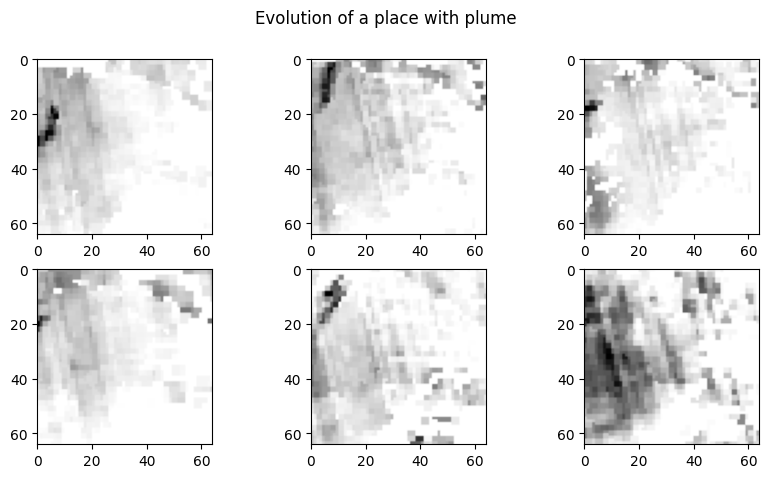

In [119]:
# This can also be used to plot
same_place1 = rasterio.open("/content/drive/MyDrive/QB/data/images/plume/20230101_methane_mixing_ratio_id_4928.tif")
same_place2 = rasterio.open("/content/drive/MyDrive/QB/data/images/plume/20230102_methane_mixing_ratio_id_4928.tif")
same_place3 = rasterio.open("/content/drive/MyDrive/QB/data/images/plume/20230118_methane_mixing_ratio_id_4928.tif")
same_place4 = rasterio.open("/content/drive/MyDrive/QB/data/images/plume/20230202_methane_mixing_ratio_id_4928.tif")
same_place5 = rasterio.open("/content/drive/MyDrive/QB/data/images/plume/20230219_methane_mixing_ratio_id_4928.tif")
same_place6 = rasterio.open("/content/drive/MyDrive/QB/data/images/plume/20230324_methane_mixing_ratio_id_4928.tif")

fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(10,5))

show(same_place1, cmap="Greys", ax=ax[0,0])
show(same_place2, cmap="Greys", ax=ax[0,1])
show(same_place3, cmap="Greys", ax=ax[0,2])
show(same_place4, cmap="Greys", ax=ax[1,0])
show(same_place5, cmap="Greys", ax=ax[1,1])
show(same_place6, cmap="Greys", ax=ax[1,2])

plt.suptitle('Evolution of a place with plume')
plt.show()

In [111]:
metadata[metadata.id_coord=='id_6675'].sort_values(by='date')

,date,id_coord,plume,set,lat,lon,coord_x,coord_y,path
97,20230115,id_6675,yes,train,31.52875,74.330625,23,47,images/plume/20230115_methane_mixing_ratio_id_...
128,20230117,id_6675,yes,train,31.52875,74.330625,22,48,images/plume/20230117_methane_mixing_ratio_id_...
85,20230126,id_6675,yes,train,31.52875,74.330625,24,49,images/plume/20230126_methane_mixing_ratio_id_...
184,20230127,id_6675,yes,train,31.52875,74.330625,24,46,images/plume/20230127_methane_mixing_ratio_id_...
72,20230131,id_6675,yes,train,31.52875,74.330625,23,47,images/plume/20230131_methane_mixing_ratio_id_...
174,20230221,id_6675,yes,train,31.52875,74.330625,22,49,images/plume/20230221_methane_mixing_ratio_id_...
0,20230223,id_6675,yes,train,31.52875,74.330625,24,47,images/plume/20230223_methane_mixing_ratio_id_...
23,20230227,id_6675,yes,train,31.52875,74.330625,23,47,images/plume/20230227_methane_mixing_ratio_id_...
82,20230327,id_6675,yes,train,31.52875,74.330625,24,51,images/plume/20230327_methane_mixing_ratio_id_...
144,20230402,id_6675,yes,train,31.52875,74.330625,24,38,images/plume/20230402_methane_mixing_ratio_id_...


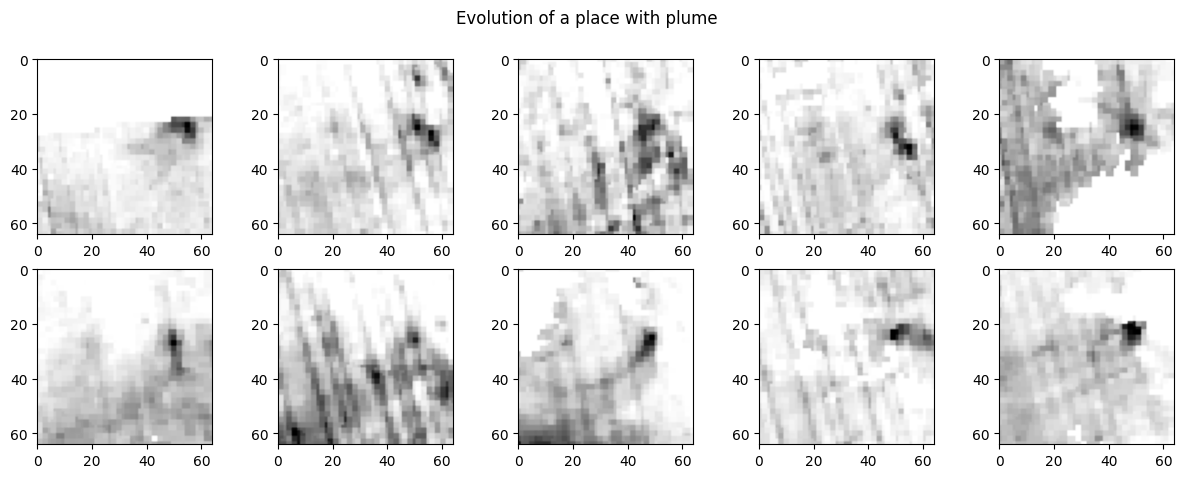

In [115]:
# This can also be used to plot
same_place1 = rasterio.open("/content/drive/MyDrive/QB/data/images/plume/20230115_methane_mixing_ratio_id_6675.tif")
same_place2 = rasterio.open("/content/drive/MyDrive/QB/data/images/plume/20230117_methane_mixing_ratio_id_6675.tif")
same_place3 = rasterio.open("/content/drive/MyDrive/QB/data/images/plume/20230126_methane_mixing_ratio_id_6675.tif")
same_place4 = rasterio.open("/content/drive/MyDrive/QB/data/images/plume/20230127_methane_mixing_ratio_id_6675.tif")
same_place5 = rasterio.open("/content/drive/MyDrive/QB/data/images/plume/20230131_methane_mixing_ratio_id_6675.tif")
same_place6 = rasterio.open("/content/drive/MyDrive/QB/data/images/plume/20230221_methane_mixing_ratio_id_6675.tif")
same_place7 = rasterio.open("/content/drive/MyDrive/QB/data/images/plume/20230223_methane_mixing_ratio_id_6675.tif")
same_place8 = rasterio.open("/content/drive/MyDrive/QB/data/images/plume/20230227_methane_mixing_ratio_id_6675.tif")
same_place9 = rasterio.open("/content/drive/MyDrive/QB/data/images/plume/20230327_methane_mixing_ratio_id_6675.tif")
same_place10 = rasterio.open("/content/drive/MyDrive/QB/data/images/plume/20230402_methane_mixing_ratio_id_6675.tif")



fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(15,5))

show(same_place1, cmap="Greys", ax=ax[0,0])
show(same_place2, cmap="Greys", ax=ax[0,1])
show(same_place3, cmap="Greys", ax=ax[0,2])
show(same_place4, cmap="Greys", ax=ax[0,3])
show(same_place5, cmap="Greys", ax=ax[0,4])
show(same_place6, cmap="Greys", ax=ax[1,0])
show(same_place7, cmap="Greys", ax=ax[1,1])
show(same_place8, cmap="Greys", ax=ax[1,2])
show(same_place9, cmap="Greys", ax=ax[1,3])
show(same_place10, cmap="Greys", ax=ax[1,4])

plt.suptitle('Evolution of a place with plume')
plt.show()

### Intensity analysis :

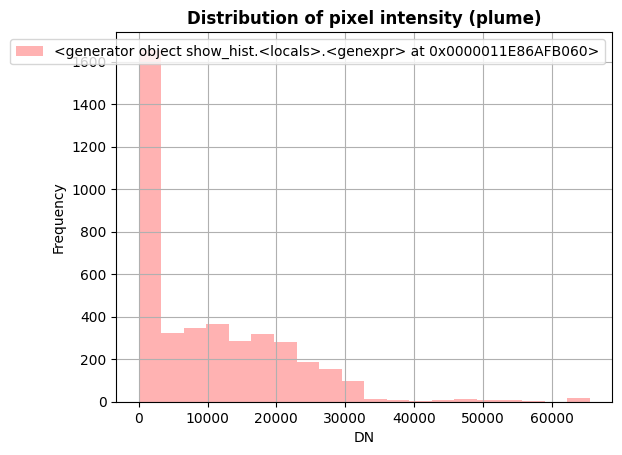

In [25]:
path='data/data/images/plume/20230101_methane_mixing_ratio_id_4928.tif'
example_image_plume = rasterio.open(path)
show_hist(example_image_plume, bins=20, alpha=0.3, title="Distribution of pixel intensity (plume)")


Intensities are quite similar across the plume and no plume images to be honest.

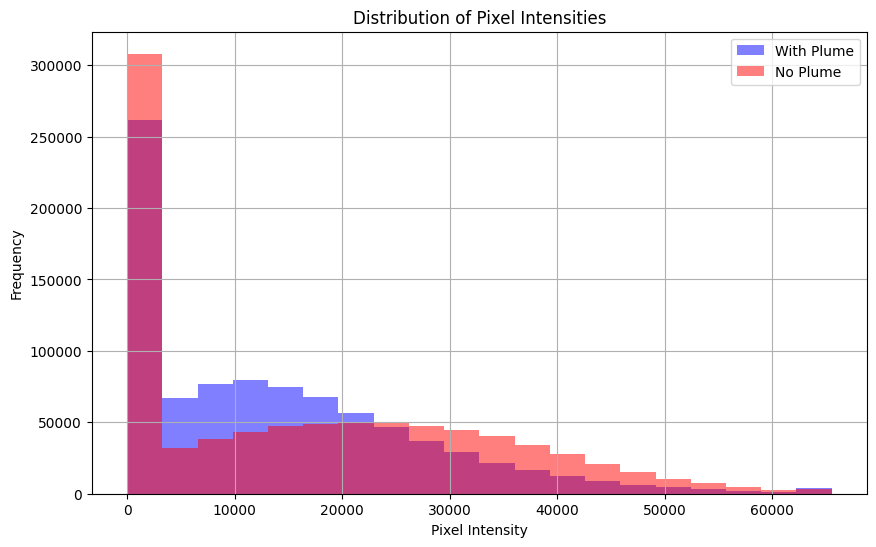

In [32]:
import matplotlib.pyplot as plt

# Flatten your image arrays to 1D, assuming your images are numpy arrays
img_plume_flattened = img_plume.ravel()
img_no_plume_flattened = img_no_plume.ravel()

# Create histogram
plt.figure(figsize=(10,6))
plt.hist(img_plume_flattened, bins=20, alpha=0.5, label='With Plume', color='b')
plt.hist(img_no_plume_flattened, bins=20, alpha=0.5, label='No Plume', color='r')
plt.legend(loc='upper right')
plt.title('Distribution of Pixel Intensities')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


## Simple Machine Learning Models

In this section I will try to build a machine learning model using a feature extractor as a benchmark

In [33]:
!pip install opencv-python-headless scikit-learn xgboost


     ---------------------------------------- 0.0/38.1 MB ? eta -:--:--
     ---------------------------------------- 0.1/38.1 MB 2.6 MB/s eta 0:00:15
     ---------------------------------------- 0.1/38.1 MB 1.7 MB/s eta 0:00:23
     ---------------------------------------- 0.2/38.1 MB 1.5 MB/s eta 0:00:26
     ---------------------------------------- 0.2/38.1 MB 1.4 MB/s eta 0:00:28
     ---------------------------------------- 0.3/38.1 MB 1.4 MB/s eta 0:00:28
     ---------------------------------------- 0.3/38.1 MB 1.2 MB/s eta 0:00:31
     ---------------------------------------- 0.4/38.1 MB 1.3 MB/s eta 0:00:30
     ---------------------------------------- 0.5/38.1 MB 1.2 MB/s eta 0:00:31
      --------------------------------------- 0.5/38.1 MB 1.2 MB/s eta 0:00:32
      --------------------------------------- 0.6/38.1 MB 1.2 MB/s eta 0:00:31
      --------------------------------------- 0.6/38.1 MB 1.2 MB/s eta 0:00:32
      --------------------------------------- 0.7/38.1 MB 1


[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: C:\Users\felip\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


### ONLY FEATURE EXTRACTOR FROM IMAGE:

In [6]:
import numpy as np

# Combine the plume and no-plume images into one dataset
images = np.concatenate((img_plume, img_no_plume), axis=0)

# Create labels for the images (1 for plume, 0 for no plume)
labels_plume = np.ones(img_plume.shape[0])
labels_no_plume = np.zeros(img_no_plume.shape[0])
labels = np.concatenate((labels_plume, labels_no_plume), axis=0)


Images analysis:
We can see images are of type uint16
And that the pixel goes from 0-65535 which is a large bit depth

In [7]:
# Check the data type of your images
print("Data type of images:", images.dtype)

# Check the minimum and maximum pixel values of your images
print("Minimum pixel value in images:", np.min(images))
print("Maximum pixel value in images:", np.max(images))

# If you want to check these properties for a specific image, you can do:
image_index = 0  # Change this to the index of the image you want to check
print(f"\nProperties of image at index {image_index}:")
print("Data type:", images[image_index].dtype)
print("Minimum pixel value:", np.min(images[image_index]))
print("Maximum pixel value:", np.max(images[image_index]))


Data type of images: uint16
Minimum pixel value in images: 0
Maximum pixel value in images: 65535

Properties of image at index 0:
Data type: uint16
Minimum pixel value: 0
Maximum pixel value: 65535


We need to rescale them to use the feature extractor but note that we are probably losing a lot of info.

In [8]:
#We convert timages pixel values to 0-255 range for orb feature extractor:
images_rescaled = (images / np.max(images) * 255).astype(np.uint8)


In [9]:
images_rescaled.shape

(428, 64, 64, 1)

In [10]:
import cv2
import numpy as np
def extract_features(images):
    orb = cv2.ORB_create(nfeatures=64)
    feature_vectors = []

    for img in images:
        keypoints, descriptors = orb.detectAndCompute(img, None)
        if descriptors is not None:
            feature_vector = np.mean(descriptors, axis=0)
        else:
            feature_vector = np.zeros((32,))
        feature_vectors.append(feature_vector)
        
    return np.array(feature_vectors)



In [11]:
images_rescaled[0].shape

(64, 64, 1)

In [12]:
features = extract_features(images_rescaled)

In [13]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)


In [14]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report

# Train the classifier
clf = XGBClassifier(use_label_encoder=False, eval_metric="logloss")
clf.fit(X_train, y_train)

# Make predictions on the test set
y_pred = clf.predict(X_test)

# Evaluate the classifier
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: {:.2f}".format(accuracy))
print("Classification Report:")
print(classification_report(y_test, y_pred))


C:\Users\felip\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Accuracy: 0.42
Classification Report:
              precision    recall  f1-score   support

         0.0       0.41      0.97      0.58        35
         1.0       0.67      0.04      0.07        51

    accuracy                           0.42        86
   macro avg       0.54      0.51      0.33        86
weighted avg       0.56      0.42      0.28        86



In [15]:
from sklearn.ensemble import RandomForestClassifier

# Train the classifier
clf = RandomForestClassifier()
clf.fit(X_train, y_train)

# Make predictions on the test set
y_pred = clf.predict(X_test)

# Evaluate the classifier
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: {:.2f}".format(accuracy))
print("Classification Report:")
print(classification_report(y_test, y_pred))


Accuracy: 0.43
Classification Report:
              precision    recall  f1-score   support

         0.0       0.41      0.97      0.58        35
         1.0       0.75      0.06      0.11        51

    accuracy                           0.43        86
   macro avg       0.58      0.52      0.35        86
weighted avg       0.61      0.43      0.30        86



In [16]:
from sklearn.svm import SVC

# Train the classifier
clf = SVC()
clf.fit(X_train, y_train)

# Make predictions on the test set
y_pred = clf.predict(X_test)

# Evaluate the classifier
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: {:.2f}".format(accuracy))
print("Classification Report:")
print(classification_report(y_test, y_pred))


Accuracy: 0.41
Classification Report:
              precision    recall  f1-score   support

         0.0       0.40      0.97      0.57        35
         1.0       0.50      0.02      0.04        51

    accuracy                           0.41        86
   macro avg       0.45      0.50      0.30        86
weighted avg       0.46      0.41      0.25        86



In [17]:
from sklearn.linear_model import LogisticRegression

# Train the classifier
clf = LogisticRegression()
clf.fit(X_train, y_train)

# Make predictions on the test set
y_pred = clf.predict(X_test)

# Evaluate the classifier
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: {:.2f}".format(accuracy))
print("Classification Report:")
print(classification_report(y_test, y_pred))


Accuracy: 0.42
Classification Report:
              precision    recall  f1-score   support

         0.0       0.41      0.94      0.57        35
         1.0       0.60      0.06      0.11        51

    accuracy                           0.42        86
   macro avg       0.50      0.50      0.34        86
weighted avg       0.52      0.42      0.30        86



### With metadata and feature extractor:

In [349]:
import os
import rasterio
import numpy as np

# Define the path to the directory containing the .tif images
dir_path_no_plume = 'C:/Users/felip/Documents/GitHub/QB_methane_classification/data/data/images/no_plume'
dir_path_plume = 'C:/Users/felip/Documents/GitHub/QB_methane_classification/data/data/images/plume'

# Create empty lists to store the loaded images and paths
images_no_plume = []
paths_no_plume = []
images_plume = []
paths_plume = []

# Function to load images and paths from a given directory
def load_images_and_paths(dir_path, images_list, paths_list):
    for file in os.listdir(dir_path):
        if file.endswith('.tif'):
            image_path = os.path.join(dir_path, file)
            with rasterio.open(image_path) as src:
                image = src.read()
                images_list.append(image)
                paths_list.append(image_path)

# Load images and paths
load_images_and_paths(dir_path_no_plume, images_no_plume, paths_no_plume)
load_images_and_paths(dir_path_plume, images_plume, paths_plume)

# Convert the lists of loaded images to numpy arrays and reshape
img_no_plume = np.array(images_no_plume)
img_no_plume = img_no_plume.reshape(214, 64, 64, 1)
img_plume = np.array(images_plume)
img_plume = img_plume.reshape(214, 64, 64, 1)


In [350]:
# Rescale images and keep the shape consistent
images_plume_rescaled = (images_plume / np.max(images_plume) * 255).astype(np.uint8)
images_plume_rescaled=images_plume_rescaled.reshape((214,64,64,1))
#images_plume_rescaled = np.expand_dims(images_plume_rescaled, axis=-1)
#images_plume_rescaled = np.squeeze(images_plume_rescaled)

images_no_plume_rescaled = (images_no_plume / np.max(images_no_plume) * 255).astype(np.uint8)
images_no_plume_rescaled=images_no_plume_rescaled.reshape((214,64,64,1))

#images_no_plume_rescaled = np.expand_dims(images_no_plume_rescaled, axis=-1)
#images_no_plume_rescaled = np.squeeze(images_no_plume_rescaled)



Now I will incorporate the metadata to my features:

In [103]:
!pip install scikit-image

     ---------------------------------------- 0.0/23.7 MB ? eta -:--:--
     ---------------------------------------- 0.1/23.7 MB 2.0 MB/s eta 0:00:12
     ---------------------------------------- 0.2/23.7 MB 2.1 MB/s eta 0:00:12
     ---------------------------------------- 0.2/23.7 MB 2.1 MB/s eta 0:00:12
      --------------------------------------- 0.3/23.7 MB 1.9 MB/s eta 0:00:13
      --------------------------------------- 0.4/23.7 MB 1.6 MB/s eta 0:00:15
      --------------------------------------- 0.5/23.7 MB 1.7 MB/s eta 0:00:14
      --------------------------------------- 0.5/23.7 MB 1.8 MB/s eta 0:00:14
     - -------------------------------------- 0.7/23.7 MB 1.9 MB/s eta 0:00:13
     - -------------------------------------- 0.8/23.7 MB 1.8 MB/s eta 0:00:13
     - -------------------------------------- 0.9/23.7 MB 1.9 MB/s eta 0:00:13
     - -------------------------------------- 1.0/23.7 MB 1.9 MB/s eta 0:00:12
     - -------------------------------------- 1.1/23.7 MB 1


[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: C:\Users\felip\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [351]:
###Fix paths to match each other:
##Note this depends on your path, Here I have my path in my computer check both paths and see.
import os

def adjust_paths(paths):
    adjusted_paths = []
    for path in paths:
        # Remove the 'C:/Users/felip/Documents/GitHub/QB_methane_classification/data/data/' prefix
        path = path.replace('C:/Users/felip/Documents/GitHub/QB_methane_classification/data/data/', '')
        # Replace backslashes with forward slashes
        path = path.replace('\\', '/')
        # Remove the '.tif' suffix
        path = os.path.splitext(path)[0]
        adjusted_paths.append(path)
    return adjusted_paths

valid_paths_no_plume = adjust_paths(paths_no_plume)
valid_paths_plume = adjust_paths(paths_plume)

NOTE THAT THE FEATURE EXTRACTOR IS PUTTING 0s WHEN IT DOESN'T FIND A DESCRIPTOR(CORRECT EMBEDDINGS)

In [352]:
import cv2
import numpy as np
def extract_features_and_paths(images,paths):
    orb = cv2.ORB_create(nfeatures=64)
    feature_vectors = []
    valid_paths=[]
    for img, path in zip(images, paths):
        keypoints, descriptors = orb.detectAndCompute(img, None)
        if descriptors is not None:
            feature_vector = np.mean(descriptors, axis=0)
        else:
            feature_vector = np.zeros((32,))
        feature_vectors.append(feature_vector)
        valid_paths.append(path)

        
    return np.array(feature_vectors),valid_paths

# Assume 'images_plume_rescaled' is your list of plume images and 'paths_plume' is your list of corresponding file paths
img_plume_features, valid_plume_paths = extract_features_and_paths(images_plume_rescaled.reshape((214,64,64,1)), valid_paths_plume)

# Assume 'images_no_plume_rescaled' is your list of no plume images and 'paths_no_plume' is your list of corresponding file paths
img_noplume_features, valid_noplume_paths = extract_features_and_paths(images_no_plume_rescaled.reshape((214,64,64,1)), valid_paths_no_plume)


Feature engineering on metadata:

In [418]:
# Combine plume and no plume datasets
all_img_features = np.concatenate((img_noplume_features,img_plume_features), axis=0)
all_paths = valid_paths_no_plume + valid_paths_plume

# Create a DataFrame with the image features and paths
img_features_metadata_df = pd.DataFrame(all_img_features)
img_features_df['path'] = all_paths

metadata_df = metadata

##Here it is important that the path match otherwise we can't merge:

# Merge the image features DataFrame with the metadata DataFrame
df = metadata_df.merge(img_features_df, on='path')


In [404]:
df

,date,id_coord,plume,set,lat,lon,coord_x,coord_y,path,month,...,22,23,24,25,26,27,28,29,30,31
0,1970-01-01 00:00:00.020230223,70,yes,train,0.148921,0.424579,24,47,images/plume/20230223_methane_mixing_ratio_id_...,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1970-01-01 00:00:00.020230103,19,yes,train,0.407509,1.215560,42,37,images/plume/20230103_methane_mixing_ratio_id_...,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1970-01-01 00:00:00.020230301,66,yes,train,-0.526290,0.644229,58,15,images/plume/20230301_methane_mixing_ratio_id_...,1,...,251.0,49.0,207.0,221.0,149.0,125.0,242.0,94.0,222.0,218.0
3,1970-01-01 00:00:00.020230225,58,yes,train,-0.158868,0.562149,28,62,images/plume/20230225_methane_mixing_ratio_id_...,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1970-01-01 00:00:00.020230105,13,yes,train,0.359909,-0.270458,59,44,images/plume/20230105_methane_mixing_ratio_id_...,1,...,253.0,47.0,127.0,111.0,128.0,209.0,231.0,103.0,86.0,114.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
425,1970-01-01 00:00:00.020230302,69,no,train,0.112600,-0.399454,39,36,images/no_plume/20230302_methane_mixing_ratio_...,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
426,1970-01-01 00:00:00.020230218,43,no,train,0.434100,-0.280861,29,28,images/no_plume/20230218_methane_mixing_ratio_...,1,...,165.0,77.0,177.0,186.0,102.0,18.0,8.0,176.0,35.0,61.0
427,1970-01-01 00:00:00.020230213,18,no,train,1.337941,-0.990190,23,10,images/no_plume/20230213_methane_mixing_ratio_...,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
428,1970-01-01 00:00:00.020230213,52,no,train,0.225358,-0.190944,55,54,images/no_plume/20230213_methane_mixing_ratio_...,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [419]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

# Convert 'date' to datetime format
df['date'] = pd.to_datetime(df['date'])

# Extract features from 'date'
df['month'] = df['date'].dt.month
df['day_of_week'] = df['date'].dt.dayofweek
df['day_of_year'] = df['date'].dt.dayofyear

# Encode 'location_id' with LabelEncoder
encoder = LabelEncoder()
df['id_coord'] = encoder.fit_transform(df['id_coord'])

# One-hot encode 'set' (train/test) 
#df = pd.get_dummies(df, columns=['set'])

# Normalize 'lat' and 'long' with StandardScaler
scaler = StandardScaler()
df[['lat', 'lon']] = scaler.fit_transform(df[['lat', 'lon']])

# Assuming 'cord_x' and 'cord_y' are the coordinates of the plume center, you can create a new feature for the distance to the center
df['center_distance'] = np.sqrt(df['coord_x']**2 + df['coord_y']**2)

# Drop unnecessary columns
df = df.drop(columns=['date', 'coord_x', 'coord_y', 'path','set'])  # 'path' is assumed to be the path to the image file

# Convert 'plume' (yes/no) to binary label
df['plume'] = df['plume'].map({'yes': 1, 'no': 0})


df.columns = df.columns.astype(str)
# Separate features and target
X = df.drop(columns=['plume'])
##My model has leakage somewhere for sure
##We can try only metadata:
#X=df[['id_coord','lat','lon','center_distance']] # something definitely wrong, I get 95 with only id_coord.

#X=df[['lat']] # something definitely wrong, I get 95 with only id_coord.
##Try only embeddings:
#X=df[['0','1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18','19','20','21','22','23','24','25','26','27','28','29','30','31']]
##Using only embeddings I get around 48 which is similar to what I got before, so the issue is when using the metadata somewhere I get data leakage.
#X.columns = X.columns.astype(str)
y = df['plume']

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [420]:
list(X_train.columns)

['id_coord',
 'lat',
 'lon',
 'month',
 'day_of_week',
 'day_of_year',
 'center_distance',
 '0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 '10',
 '11',
 '12',
 '13',
 '14',
 '15',
 '16',
 '17',
 '18',
 '19',
 '20',
 '21',
 '22',
 '23',
 '24',
 '25',
 '26',
 '27',
 '28',
 '29',
 '30',
 '31']

My results when I only use the metadata make no sense, I get almost 1 or 1 everytime.
In particular, If I only use center distance I get 85, if I use only id_coord I get 95
If I only use lon I get 1 
If I only use Lat I get: 99
And all of this is without even using the embeddings from the image, I don't know what is wrong but something definitely is.

In [421]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report

# Train the classifier
clf = XGBClassifier(use_label_encoder=False, eval_metric="logloss")
clf.fit(X_train, y_train)

# Make predictions on the test set
y_pred = clf.predict(X_test)

# Evaluate the classifier
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: {:.2f}".format(accuracy))
print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 1.00
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        35
           1       1.00      1.00      1.00        51

    accuracy                           1.00        86
   macro avg       1.00      1.00      1.00        86
weighted avg       1.00      1.00      1.00        86



C:\Users\felip\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


In [422]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report
from sklearn.model_selection import cross_validate, StratifiedKFold

# Train the classifier with cross-validation
clf = XGBClassifier(use_label_encoder=False, eval_metric="logloss")
cv_results = cross_validate(clf, X_train, y_train, cv=5,
                            scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'])

# Get the average scores from cross-validation
cv_accuracy = cv_results['test_accuracy'].mean()
cv_precision = cv_results['test_precision'].mean()
cv_recall = cv_results['test_recall'].mean()
cv_f1 = cv_results['test_f1'].mean()
cv_auc = cv_results['test_roc_auc'].mean()

print("Cross-Validation Results:")
print("Accuracy: {:.2f}".format(cv_accuracy))
print("Precision: {:.2f}".format(cv_precision))
print("Recall: {:.2f}".format(cv_recall))
print("F1 Score: {:.2f}".format(cv_f1))
print("AUC: {:.2f}".format(cv_auc))

# Fit the classifier on the entire training set
clf.fit(X_train, y_train)

# Make predictions on the test set
y_pred = clf.predict(X_test)
y_pred_proba = clf.predict_proba(X_test)[:, 1]

# Evaluate the classifier on the test set
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred_proba)

print("Test Set Results:")
print("Accuracy: {:.2f}".format(accuracy))
print("Precision: {:.2f}".format(precision))
print("Recall: {:.2f}".format(recall))
print("F1 Score: {:.2f}".format(f1))
print("AUC: {:.2f}".format(auc))

print("Classification Report:")
print(classification_report(y_test, y_pred))


C:\Users\felip\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
C:\Users\felip\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
C:\Users\felip\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
C:\Users\felip\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\xgboost\s

Cross-Validation Results:
Accuracy: 0.98
Precision: 0.97
Recall: 0.98
F1 Score: 0.98
AUC: 0.99
Test Set Results:
Accuracy: 1.00
Precision: 1.00
Recall: 1.00
F1 Score: 1.00
AUC: 1.00
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        35
           1       1.00      1.00      1.00        51

    accuracy                           1.00        86
   macro avg       1.00      1.00      1.00        86
weighted avg       1.00      1.00      1.00        86



C:\Users\felip\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


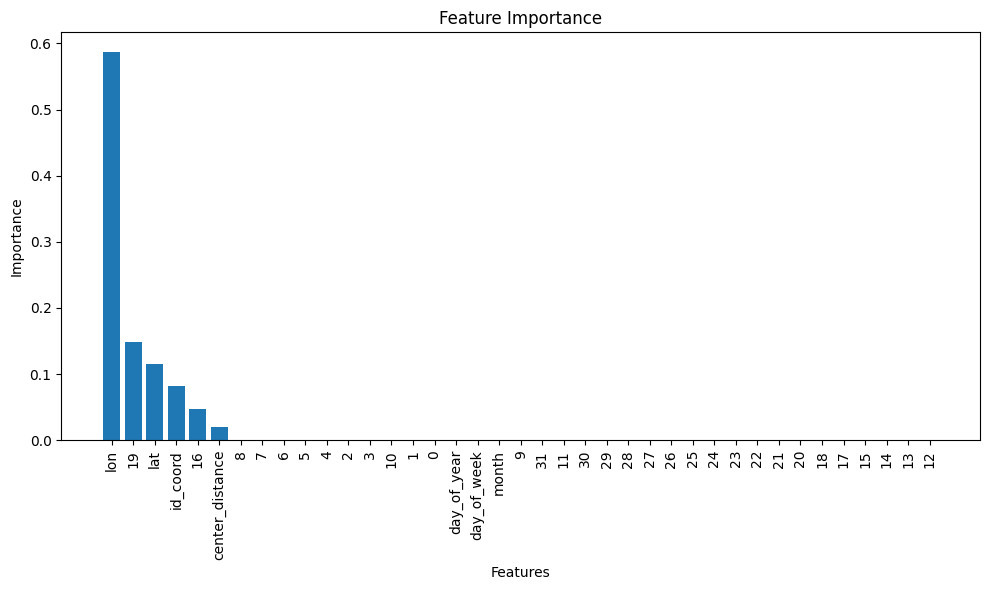

In [409]:
from xgboost import XGBClassifier
import matplotlib.pyplot as plt

# Train the classifier
clf = XGBClassifier(use_label_encoder=False, eval_metric="logloss")
clf.fit(X_train, y_train)

# Get feature importances
importance = clf.feature_importances_
features = X_train.columns

# Sort feature importances in descending order
indices = np.argsort(importance)[::-1]
sorted_features = [features[i] for i in indices]

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.bar(range(len(importance)), importance[indices])
plt.xticks(range(len(importance)), sorted_features, rotation='vertical')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importance')
plt.tight_layout()
plt.show()


In [410]:
from sklearn.ensemble import RandomForestClassifier

# Train the classifier
clf = RandomForestClassifier()
clf.fit(X_train, y_train)

# Make predictions on the test set
y_pred = clf.predict(X_test)

# Evaluate the classifier
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: {:.2f}".format(accuracy))
print("Classification Report:")
print(classification_report(y_test, y_pred))


Accuracy: 0.97
Classification Report:
              precision    recall  f1-score   support

           0       0.92      1.00      0.96        35
           1       1.00      0.94      0.97        51

    accuracy                           0.97        86
   macro avg       0.96      0.97      0.96        86
weighted avg       0.97      0.97      0.97        86



In [411]:
from sklearn.ensemble import RandomForestClassifier

# Train the classifier
clf = RandomForestClassifier()
clf.fit(X_train, y_train)

# Make predictions on the test set
y_pred = clf.predict(X_test)

# Evaluate the classifier
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: {:.2f}".format(accuracy))
print("Classification Report:")
print(classification_report(y_test, y_pred))


Accuracy: 0.97
Classification Report:
              precision    recall  f1-score   support

           0       0.92      1.00      0.96        35
           1       1.00      0.94      0.97        51

    accuracy                           0.97        86
   macro avg       0.96      0.97      0.96        86
weighted avg       0.97      0.97      0.97        86



## Neural Network approach:

### Without Metadata

Lets re read the data to make sure everything is okay.

In [25]:
# Load the images
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
# FIRST THE NO PLUME

# Define the path to the directory containing the .tif images
#dir_path = '/content/drive/MyDrive/QB/data/images/no_plume'
dir_path='C:/Users/felip/Documents/GitHub/QB_methane_classification/data/data/images/no_plume'

# Create an empty list to store the loaded images
images = []

# Loop through all the .tif files in the directory
for file in os.listdir(dir_path):
    if file.endswith('.tif'):
        # Open the .tif file using rasterio
        with rasterio.open(os.path.join(dir_path, file)) as src:
            # Read the raster data as a NumPy array
            image = src.read()
            # Reverse the scale of the image
            #max_val = np.iinfo(image.dtype).max
            #image = max_val - image
            # Append the image to the list of loaded images
            images.append(image)

# Convert the list of loaded images to a numpy array
img_no_plume = np.array(images)
img_no_plume = img_no_plume.reshape(214, 64, 64, 1)

# THEN THE PLUME
# Define the path to the directory containing the .tif images
#dir_path = '/content/drive/MyDrive/QB/data/images/plume'
dir_path='C:/Users/felip/Documents/GitHub/QB_methane_classification/data/data/images/plume'
# Create an empty list to store the loaded images
images = []

# Loop through all the .tif files in the directory
for file in os.listdir(dir_path):
    if file.endswith('.tif'):
        # Open the .tif file using rasterio
        with rasterio.open(os.path.join(dir_path, file)) as src:
            # Read the raster data as a NumPy array
            image = src.read()
            # Reverse the scale of the image
            #max_val = np.iinfo(image.dtype).max
            #image = max_val - image
            # Append the image to the list of loaded images
            images.append(image)

# Convert the list of loaded images to a numpy array
img_plume = np.array(images)
img_plume = img_plume.reshape(214, 64, 64, 1)

In [26]:
##We concatenate images again:
import numpy as np

# Combine the plume and no-plume images into one dataset
images = np.concatenate((img_plume, img_no_plume), axis=0)

# Create labels for the images (1 for plume, 0 for no plume)
labels_plume = np.ones(img_plume.shape[0])
labels_no_plume = np.zeros(img_no_plume.shape[0])
labels = np.concatenate((labels_plume, labels_no_plume), axis=0)

In [119]:
from sklearn.model_selection import train_test_split

# Split the data into train, validation, and test sets
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

# Verify the shapes of the train, validation, and test sets
print("Train set:", X_train.shape, y_train.shape)
print("Validation set:", X_val.shape, y_val.shape)
print("Test set:", X_test.shape, y_test.shape)


Train set: (256, 64, 64, 1) (256,)
Validation set: (86, 64, 64, 1) (86,)
Test set: (86, 64, 64, 1) (86,)


In [120]:
## We trnasform them to tensors:
X_train_tensor = torch.tensor(X_train.astype(np.float32), dtype=torch.float32)
y_train_tensor = torch.from_numpy(y_train).long()
X_val_tensor = torch.tensor(X_val.astype(np.float32), dtype=torch.float32)
y_val_tensor = torch.from_numpy(y_val).long()
X_test_tensor = torch.tensor(X_test.astype(np.float32), dtype=torch.float32)
y_test_tensor = torch.from_numpy(y_test).long()


Implementation without any fancy stuff just added dropout + weight decay but no data augmentation / clearly overfitting. but not too bad ~74%

In [35]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(64 * 16 * 16, 128)  # Adjusted based on image size
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, 2)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x


# Create an instance of the neural network
model = Net()
device='cpu'
# Convert the data to PyTorch tensors
X_images_tensor = torch.tensor(images.astype(np.float32), dtype=torch.float32)
y_tensor = torch.from_numpy(labels).long()  # Convert labels to PyTorch tensor

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.0001)

# Training loop
num_epochs = 40
batch_size = 32
num_train_batches = len(X_train_tensor) // batch_size

# Initialize variables for early stopping
best_loss = float('inf')
patience = 3
early_stop_counter = 0


for epoch in range(num_epochs):
    model.train()  # Set the model in training mode

    total_loss = 0
    total_correct = 0

    for batch in range(num_train_batches):
        # Extract the current batch from the tensors
        start_idx = batch * batch_size
        end_idx = start_idx + batch_size
        inputs = X_train_tensor[start_idx:end_idx]
        targets = y_train_tensor[start_idx:end_idx]
        ##For gpu
        inputs = inputs.to(device)
        targets = targets.to(device)
        
        optimizer.zero_grad()  # Zero the gradients
        inputs = inputs.reshape((batch_size, 1, 64, 64))  # Reshape the inputs

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Calculate accuracy
        _, predicted = torch.max(outputs, 1)
        total_correct += (predicted == targets).sum().item()

        total_loss += loss.item()

    # Calculate average loss and accuracy for the epoch
    train_avg_loss = total_loss / num_train_batches
    train_accuracy = total_correct / (num_train_batches * batch_size) * 100

    # Validation
    model.eval()  # Set the model in evaluation mode
    with torch.no_grad():
        val_loss = 0
        val_correct = 0
        num_val_batches = len(X_val_tensor) // batch_size

        for val_batch in range(num_val_batches):
            val_start_idx = val_batch * batch_size
            val_end_idx = val_start_idx + batch_size
            val_inputs = X_val_tensor[val_start_idx:val_end_idx]
            val_targets = y_val_tensor[val_start_idx:val_end_idx]

            val_inputs = val_inputs.reshape((batch_size, 1, 64, 64))  # Reshape the validation inputs
            #For gpu
            val_inputs = val_inputs.to(device)
            val_targets = val_targets.to(device)
            val_outputs = model(val_inputs)
            val_loss += criterion(val_outputs, val_targets).item()

            _, val_predicted = torch.max(val_outputs, 1)
            val_correct += (val_predicted == val_targets).sum().item()

        
        val_avg_loss = val_loss / num_val_batches
        val_accuracy = val_correct / (num_val_batches * batch_size) * 100

    # Print the loss and accuracy for every epoch
    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {train_avg_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%")
    print(f"Validation Loss: {val_avg_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")



# Evaluate on the test set
model.eval()  # Set the model in evaluation mode
with torch.no_grad():
    test_loss = 0
    test_correct = 0
    num_test_batches = len(X_test_tensor) // batch_size

    for test_batch in range(num_test_batches):
        test_start_idx = test_batch * batch_size
        test_end_idx = test_start_idx + batch_size
        test_inputs = X_test_tensor[test_start_idx:test_end_idx]
        test_targets = y_test_tensor[test_start_idx:test_end_idx]

        test_inputs = test_inputs.reshape((batch_size, 1, 64, 64))  # Reshape the test inputs

        test_outputs = model(test_inputs)
        test_loss += criterion(test_outputs, test_targets).item()

        _, test_predicted = torch.max(test_outputs, 1)
        test_correct += (test_predicted == test_targets).sum().item()

    test_avg_loss = test_loss / num_test_batches
    test_accuracy = test_correct / (num_test_batches * batch_size) * 100

# Print the test loss and accuracy
print(f"Test Loss: {test_avg_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

# Save the trained model
torch.save(model.state_dict(), 'satellite_model.pth')


Epoch 1/40
Train Loss: 2828.2661, Train Accuracy: 49.61%
Validation Loss: 272.8730, Validation Accuracy: 53.12%
Epoch 2/40
Train Loss: 688.3211, Train Accuracy: 57.81%
Validation Loss: 226.0848, Validation Accuracy: 53.12%
Epoch 3/40
Train Loss: 353.4637, Train Accuracy: 59.77%
Validation Loss: 140.1348, Validation Accuracy: 54.69%
Epoch 4/40
Train Loss: 218.8404, Train Accuracy: 59.77%
Validation Loss: 70.1125, Validation Accuracy: 62.50%
Epoch 5/40
Train Loss: 55.9797, Train Accuracy: 79.30%
Validation Loss: 63.1640, Validation Accuracy: 60.94%
Epoch 6/40
Train Loss: 43.4661, Train Accuracy: 80.86%
Validation Loss: 22.4101, Validation Accuracy: 68.75%
Epoch 7/40
Train Loss: 26.5948, Train Accuracy: 80.47%
Validation Loss: 22.4695, Validation Accuracy: 70.31%
Epoch 8/40
Train Loss: 17.3502, Train Accuracy: 85.16%
Validation Loss: 21.2237, Validation Accuracy: 70.31%
Epoch 9/40
Train Loss: 12.5260, Train Accuracy: 92.19%
Validation Loss: 21.5529, Validation Accuracy: 79.69%
Epoch 10/40

With the one above, simple, I can get around 78% on test set

In [40]:
pip install torchvision

  Using cached torchvision-0.15.2-cp310-cp310-win_amd64.whl (1.2 MB)
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: C:\Users\felip\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [121]:
import torch
import torchvision.transforms as transforms

class DatasetWithTransform(torch.utils.data.Dataset):
    def __init__(self, dataset, transform):
        self.dataset = dataset
        self.transform = transform

    def __getitem__(self, index):
        x, y = self.dataset[index]
        x = self.transform(x)
        return x, y

    def __len__(self):
        return len(self.dataset)



## data augmentation:
# Data augmentation transforms
train_transforms = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip()#,
    #transforms.ToTensor(),
])

##More transformations:
#train_transforms = transforms.Compose([
#    transforms.RandomRotation(10),
#    transforms.RandomHorizontalFlip(),
#    transforms.RandomVerticalFlip(),
#    #transforms.GaussianBlur(kernel_size=3),
#    #transforms.RandomAffine(degrees=10, translate=(0.1, 0.1), scale=(0.8, 1.2), shear=10),
#    transforms.RandomErasing(p=0.5, scale=(0.02, 0.1))
#    #transforms.RandomCrop(48,48),  # Randomly crop a 60x60 region
#    #transforms.RandomResizedCrop(64),  # Randomly crop and resize to 64x64
#    #transforms.ToTensor(),
#    #transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize the image
#])


# Create datasets and data loaders
train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
#print(type(train_dataset[0][0]))
# Apply transformations to the training dataset
train_dataset = DatasetWithTransform(train_dataset, train_transforms)

val_dataset = torch.utils.data.TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = torch.utils.data.TensorDataset(X_test_tensor, y_test_tensor)




train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)


In [104]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision.models as models

class Net(nn.Module):
    def __init__(self, dropout_rate=0.5):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.fc1 = nn.Linear(64 * 16 * 16, 128)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(128, 2)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x



# Create an instance of the neural network
model = Net()

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)

# Learning rate scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.2)

# Training loop
num_epochs = 50
best_val_loss = float('inf')
early_stop_counter = 0
patience=60
batch_size = 32

# Training loop
for epoch in range(num_epochs):
    model.train()  # Set the model in training mode

    total_loss = 0
    total_correct = 0

    for batch, (inputs, targets) in enumerate(train_loader):
        optimizer.zero_grad()  # Zero the gradients
        
        # Adjust batch size for the last batch
        batch_size = inputs.size(0) # taking care of batches with less than 32
        
        inputs = inputs.reshape((batch_size, 1, 64, 64))  # Reshape the inputs
        inputs = inputs.to(device)
        targets = targets.to(device)
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Calculate accuracy
        _, predicted = torch.max(outputs, 1)
        total_correct += (predicted == targets).sum().item()

        total_loss += loss.item()

    # Calculate average loss and accuracy for the epoch
    train_avg_loss = total_loss / len(train_loader)
    train_accuracy = total_correct / len(train_dataset) * 100

    # Validation
    model.eval()  # Set the model in evaluation mode
    with torch.no_grad():
        val_loss = 0
        val_correct = 0

        for inputs, targets in val_loader:
            batch_size = inputs.size(0) # taking care of batches with less than 32

            inputs = inputs.reshape((batch_size, 1, 64, 64))  # Reshape the validation inputs
            ##To use gpu:
            inputs = inputs.to(device)
            targets = targets.to(device)
            
            val_outputs = model(inputs)
            val_loss += criterion(val_outputs, targets).item()

            _, val_predicted = torch.max(val_outputs, 1)
            val_correct += (val_predicted == targets).sum().item()

        val_avg_loss = val_loss / len(val_loader)
        val_accuracy = val_correct / len(val_dataset) * 100

    # Print the loss and accuracy for every epoch
    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {train_avg_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%")
    print(f"Validation Loss: {val_avg_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

    # Check if validation loss improved, if not, increment early_stop_counter
    if val_avg_loss >= best_val_loss:
        early_stop_counter += 1
    else:
        best_val_loss = val_avg_loss
        early_stop_counter = 0

    # Stop training if early stopping condition is met
    if early_stop_counter >= patience:
        print("Early stopping triggered!")
        break

    # Adjust learning rate
    scheduler.step()


# Test
model.eval()  # Set the model in evaluation mode
test_loss = 0.0
test_correct = 0

with torch.no_grad():
    for inputs, targets in test_loader:
        inputs = inputs.reshape((-1, 1, 64, 64))  # Reshape the test inputs

        test_outputs = model(inputs)
        test_loss += criterion(test_outputs, targets).item()

        _, test_predicted = torch.max(test_outputs, 1)
        test_correct += (test_predicted == targets).sum().item()
        
##Calculate average loss and accuracy for test:
test_avg_loss = test_loss / len(test_loader)
test_accuracy = test_correct / len(test_dataset) * 100

# Print the test loss and accuracy
print(f"Test Loss: {test_avg_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

# Save the trained model
torch.save(model.state_dict(), 'satellite_model.pth')


Epoch 1/50
Train Loss: 2.1816, Train Accuracy: 54.30%
Validation Loss: 4.7608, Validation Accuracy: 51.16%
Epoch 2/50
Train Loss: 0.9706, Train Accuracy: 60.94%
Validation Loss: 0.8923, Validation Accuracy: 63.95%
Epoch 3/50
Train Loss: 0.6732, Train Accuracy: 60.94%
Validation Loss: 0.6756, Validation Accuracy: 66.28%
Epoch 4/50
Train Loss: 0.6408, Train Accuracy: 64.06%
Validation Loss: 0.6146, Validation Accuracy: 60.47%
Epoch 5/50
Train Loss: 0.6175, Train Accuracy: 61.72%
Validation Loss: 0.5613, Validation Accuracy: 73.26%
Epoch 6/50
Train Loss: 0.5916, Train Accuracy: 64.45%
Validation Loss: 0.5762, Validation Accuracy: 68.60%
Epoch 7/50
Train Loss: 0.5897, Train Accuracy: 65.23%
Validation Loss: 0.5138, Validation Accuracy: 77.91%
Epoch 8/50
Train Loss: 0.6385, Train Accuracy: 66.02%
Validation Loss: 0.4922, Validation Accuracy: 79.07%
Epoch 9/50
Train Loss: 0.5654, Train Accuracy: 69.53%
Validation Loss: 0.7470, Validation Accuracy: 59.30%
Epoch 10/50
Train Loss: 0.5786, Train

### Trying a pre-trained model

Note, most pre-trained models are trained on rgb images so it is important to consider how to adapt them to greyscale, for example, adding channels to the greyscale. I think it doesn't change much whether we expand the greyscale to 3 channels, or trim the model to 1 channel.

Trying different pre-trained models --> for now I got 82 % as best performance but we still need to deal with the data leakage issue.

In [116]:
!pip install timm

     ---------------------------------------- 0.0/2.2 MB ? eta -:--:--
     - -------------------------------------- 0.1/2.2 MB 1.3 MB/s eta 0:00:02
     --- ------------------------------------ 0.2/2.2 MB 2.0 MB/s eta 0:00:02
     ---- ----------------------------------- 0.2/2.2 MB 1.8 MB/s eta 0:00:02
     ----- ---------------------------------- 0.3/2.2 MB 1.5 MB/s eta 0:00:02
     ------ --------------------------------- 0.4/2.2 MB 1.6 MB/s eta 0:00:02
     ------- -------------------------------- 0.4/2.2 MB 1.5 MB/s eta 0:00:02
     --------- ------------------------------ 0.5/2.2 MB 1.6 MB/s eta 0:00:02
     ---------- ----------------------------- 0.6/2.2 MB 1.6 MB/s eta 0:00:01
     ------------ --------------------------- 0.7/2.2 MB 1.6 MB/s eta 0:00:01
     ------------- -------------------------- 0.8/2.2 MB 1.7 MB/s eta 0:00:01
     --------------- ------------------------ 0.8/2.2 MB 1.7 MB/s eta 0:00:01
     ----------------- ---------------------- 0.9/2.2 MB 1.7 MB/s eta 0


[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: C:\Users\felip\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [122]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision.models as models
from torchvision.transforms import Grayscale, ToTensor
import timm
# Load pre-trained ResNet model
#pretrained_model = models.resnetrs50(pretrained=True)
model=timm.create_model('resnetrs50',pretrained=True,in_chans=1)
# Modify the input channels of the first convolutional layer
#pretrained_model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

# Modify the last layer to match your task
#num_classes = 2
#pretrained_model.fc = nn.Linear(pretrained_model.fc.in_features, num_classes)

# Create an instance of the neural network
#model = pretrained_model

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)

# Learning rate scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.2)

# Training loop
num_epochs = 15
best_val_loss = float('inf')
early_stop_counter = 0
patience=60
batch_size = 32

# Best model state
best_model_state = None
# Training loop
for epoch in range(num_epochs):
    model.train()  # Set the model in training mode

    total_loss = 0
    total_correct = 0

    for batch, (inputs, targets) in enumerate(train_loader):
        optimizer.zero_grad()  # Zero the gradients
        
        # Adjust batch size for the last batch
        batch_size = inputs.size(0) # taking care of batches with less than 32
        
        inputs = inputs.reshape((batch_size, 1, 64, 64))  # Reshape the inputs
        inputs = inputs.to(device)
        targets = targets.to(device)
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Calculate accuracy
        _, predicted = torch.max(outputs, 1)
        total_correct += (predicted == targets).sum().item()

        total_loss += loss.item()

    # Calculate average loss and accuracy for the epoch
    train_avg_loss = total_loss / len(train_loader)
    train_accuracy = total_correct / len(train_dataset) * 100

    # Validation
    model.eval()  # Set the model in evaluation mode
    with torch.no_grad():
        val_loss = 0
        val_correct = 0

        for inputs, targets in val_loader:
            batch_size = inputs.size(0) # taking care of batches with less than 32

            inputs = inputs.reshape((batch_size, 1, 64, 64))  # Reshape the validation inputs
            ##To use gpu:
            inputs = inputs.to(device)
            targets = targets.to(device)
            
            val_outputs = model(inputs)
            val_loss += criterion(val_outputs, targets).item()

            _, val_predicted = torch.max(val_outputs, 1)
            val_correct += (val_predicted == targets).sum().item()

        val_avg_loss = val_loss / len(val_loader)
        val_accuracy = val_correct / len(val_dataset) * 100

    # Print the loss and accuracy for every epoch
    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {train_avg_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%")
    print(f"Validation Loss: {val_avg_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

    # Check if validation loss improved, if not, increment early_stop_counter
    if val_avg_loss >= best_val_loss:
        early_stop_counter += 1
    else:
        best_val_loss = val_avg_loss
        early_stop_counter = 0
        print('Saving best model')
        best_model_state = model.state_dict()  # Save the best model state


    # Stop training if early stopping condition is met
    if early_stop_counter >= patience:
        print("Early stopping triggered!")
        break

    # Adjust learning rate
    scheduler.step()



# Test
if best_model_state is not None:
    print('LOAD BEST MODEL:')
    model.load_state_dict(best_model_state)  # Load the best model state
    
model.eval()  # Set the model in evaluation mode
test_loss = 0.0
test_correct = 0

with torch.no_grad():
    for inputs, targets in test_loader:
        inputs = inputs.reshape((-1, 1, 64, 64))  # Reshape the test inputs

        test_outputs = model(inputs)
        test_loss += criterion(test_outputs, targets).item()

        _, test_predicted = torch.max(test_outputs, 1)
        test_correct += (test_predicted == targets).sum().item()
        
##Calculate average loss and accuracy for test:
test_avg_loss = test_loss / len(test_loader)
test_accuracy = test_correct / len(test_dataset) * 100

# Print the test loss and accuracy
print(f"Test Loss: {test_avg_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

# Save the trained model
torch.save(model.state_dict(), 'satellite_model.pth')


Epoch 1/15
Train Loss: 2.7611, Train Accuracy: 47.66%
Validation Loss: 0.6831, Validation Accuracy: 67.44%
Saving best model
Epoch 2/15
Train Loss: 0.6133, Train Accuracy: 76.95%
Validation Loss: 0.6901, Validation Accuracy: 73.26%
Epoch 3/15
Train Loss: 0.5138, Train Accuracy: 80.08%
Validation Loss: 0.5731, Validation Accuracy: 69.77%
Saving best model
Epoch 4/15
Train Loss: 0.4718, Train Accuracy: 80.86%
Validation Loss: 0.5016, Validation Accuracy: 76.74%
Saving best model
Epoch 5/15
Train Loss: 0.3146, Train Accuracy: 89.06%
Validation Loss: 0.4806, Validation Accuracy: 79.07%
Saving best model
Epoch 6/15
Train Loss: 0.2337, Train Accuracy: 90.23%
Validation Loss: 0.8610, Validation Accuracy: 68.60%
Epoch 7/15
Train Loss: 0.4101, Train Accuracy: 85.94%
Validation Loss: 1.6418, Validation Accuracy: 63.95%
Epoch 8/15
Train Loss: 0.3761, Train Accuracy: 85.94%
Validation Loss: 0.5118, Validation Accuracy: 82.56%
Epoch 9/15
Train Loss: 0.2042, Train Accuracy: 92.97%
Validation Loss: 1

### With Metadata to do, its always kind of hard to merge based on the path.

In [427]:
###Metadata feature engineering:
metadata_df['date'] = pd.to_datetime(metadata_df['date'])

# Extract features from 'date'
metadata_df['month'] = metadata_df['date'].dt.month
metadata_df['day_of_week'] = metadata_df['date'].dt.dayofweek
metadata_df['day_of_year'] = metadata_df['date'].dt.dayofyear

# Encode 'location_id' with LabelEncoder
encoder = LabelEncoder()
metadata_df['id_coord'] = encoder.fit_transform(metadata_df['id_coord'])


# Normalize 'lat' and 'long' with StandardScaler
scaler = StandardScaler()
metadata_df[['lat', 'lon']] = scaler.fit_transform(metadata_df[['lat', 'lon']])

# Assuming 'cord_x' and 'cord_y' are the coordinates of the plume center, you can create a new feature for the distance to the center
metadata_df['center_distance'] = np.sqrt(metadata_df['coord_x']**2 + metadata_df['coord_y']**2)

# Drop unnecessary columns
metadata_df = metadata_df.drop(columns=['date', 'coord_x', 'coord_y', 'path','set'])  # 'path' is assumed to be the path to the image file

# Convert 'plume' (yes/no) to binary label
metadata_df['plume'] = metadata_df['plume'].map({'yes': 1, 'no': 0})


metadata_df.columns = metadata_df.columns.astype(str)

In [437]:
metadata_df.dtypes
plume=metadata_df['plume']

In [439]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

# Define the neural network model
class SatelliteNet(nn.Module):
    def __init__(self, input_size):
        super(SatelliteNet, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 2)  # Output layer with 2 classes
    
    def forward(self, x):
        x = torch.flatten(x, 1)  # Flatten the input
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Define a custom dataset to combine image and metadata
class SatelliteDataset(Dataset):
    def __init__(self, images, metadata, labels):
        self.images = images
        self.metadata = metadata
        self.labels = labels
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image = self.images[idx]
        metadata = self.metadata[idx]
        label = self.labels[idx]
        return image, metadata, label

# Combine the image data and metadata features into a single tensor
def combine_features(image, metadata):
    return torch.cat((image.view(-1), metadata), dim=0)

# Initialize the model
input_size = 64 * 64 + len(metadata_df)  # Update based on your metadata features
model = SatelliteNet(input_size)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Convert the data to PyTorch tensors
X_images_tensor = torch.tensor(images.astype(np.float32), dtype=torch.float32)
X_metadata_tensor = torch.tensor(metadata_df.drop('plume',axis=1).values, dtype=torch.float32)
y_tensor = torch.tensor(metadata_df['plume'].values, dtype=torch.long)


# Create a dataset object
dataset = SatelliteDataset(X_images_tensor, X_metadata_tensor, y_tensor)

# Split the dataset into training and test sets
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_set, test_set = torch.utils.data.random_split(dataset, [train_size, test_size])

# Create data loaders
train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
test_loader = DataLoader(test_set, batch_size=32)

# Training loop
num_epochs = 10

for epoch in range(num_epochs):
    running_loss = 0.0
    for images, metadata, labels in train_loader:
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Combine the image and metadata features
        inputs = combine_features(images, metadata)
        
        # Forward pass
        outputs = model(inputs)
        
        # Compute the loss
        loss = criterion(outputs, labels)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    # Print the average loss for the epoch
    epoch_loss = running_loss / len(train_loader)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}')

# Evaluation
model.eval()
total_correct = 0
total_samples = 0

for images, metadata, labels in test_loader:
    inputs = combine_features(images, metadata)
    outputs = model(inputs)
    _, predicted = torch.max(outputs, dim=1)
    total_correct += (predicted == labels).sum().item()
    total_samples += labels.size(0)

accuracy = total_correct / total_samples
print(f'Accuracy: {accuracy * 100:.2f}%')

# Save the trained model
torch.save(model.state_dict(), 'satellite_model.pth')


RuntimeError: Tensors must have same number of dimensions: got 1 and 2